## Installing libraries

In [1]:
#!pip install node2vec
#!pip install neo4j

## Importing Libraries

In [81]:
import numpy as np
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
from neo4j import GraphDatabase
import gensim.downloader as api
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score

## Connecting to the neo4j database

In [82]:
uri = "bolt://localhost:7687"
username = "neo4j"
password = "OLIV00%%"

driver = GraphDatabase.driver(uri, auth=(username, password))

In [83]:
# Function to fetch graph data from Neo4j
def fetch_graph_data():
    with driver.session() as session:
        result = session.run(
            "MATCH (n1)-[r]->(n2) RETURN id(n1) AS start, id(n2) AS end, type(r) AS relationship"
        )
        data = [(record["start"], record["end"], record["relationship"]) for record in result]
    return data

# Load graph data
graph_data = fetch_graph_data()

## Convert the graph data into adjacency matrix

In [84]:
# Create a directed graph using NetworkX
G = nx.DiGraph()

# Add nodes and edges to the graph
for start, end, relationship in graph_data:
    G.add_node(start)
    G.add_node(end)
    G.add_edge(start, end, relationship=relationship)

# Create the adjacency matrix
adj_matrix = nx.to_numpy_matrix(G, dtype=int)

# Get the node order in the adjacency matrix
node_order = sorted(G.nodes())

# Create a dictionary to map node IDs to indices in the adjacency matrix
node_index_map = {node_id: index for index, node_id in enumerate(node_order)}

# Rearrange the adjacency matrix based on the node order
adj_matrix_reordered = np.array([[adj_matrix[node_index_map[start], node_index_map[end]] for end in node_order] for start in node_order])

# Print the adjacency matrix
print(adj_matrix_reordered)

[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

# 1. Link Prediction using Logistic Regression

### Step 1: Generate positive and negative

In [85]:
# Assuming you have node features in 'node_features' and the adjacency matrix in 'adj_matrix'

# Positive examples: Existing edges in the graph
# Negative examples: Non-existent edges in the graph

def generate_positive_examples(adj_matrix):
    pos_edges = np.array(np.where(adj_matrix == 1)).T
    return pos_edges

def generate_negative_examples(adj_matrix):
    neg_edges = np.array(np.where(adj_matrix == 0)).T
    return neg_edges

pos_edges = generate_positive_examples(adj_matrix_reordered)
neg_edges = generate_negative_examples(adj_matrix_reordered)

In [86]:
print("Positive edges: {}".format(pos_edges.shape))
print()
print("Negative edges: {}".format(neg_edges.shape))

Positive edges: (17, 2)

Negative edges: (559, 2)


### Step 2: Create labels for the positive and negative examples

In [87]:
pos_labels = np.ones(pos_edges.shape[0])
neg_labels = np.zeros(neg_edges.shape[0])

### Step 3: Combine positive and negative examples and labels

In [88]:
edges = np.vstack((pos_edges, neg_edges))
labels = np.concatenate((pos_labels, neg_labels))

In [89]:
labels = labels.reshape(576, 1)

In [93]:
print("Edges: {}".format(edges.shape))
print("\nLabels: {}".format(labels.shape))

Edges: (576, 2)

Labels: (576, 1)


### Step 4: Split the data into training and test sets

In [94]:
X_train, X_test, y_train, y_test = train_test_split(edges, labels, test_size=0.2, random_state=42)

### Step 5: Train a supervised learning model (logistic regression) on the training data

In [95]:
logr_model = LogisticRegression()
logr_model.fit(X_train, y_train)

C:\Users\olivi\anaconda3\envs\Py_env\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

### Step 6: Evaluate the model on the test data

In [96]:
accuracy = logr_model.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9568965517241379




### Step 7: Perform cross-validation

In [97]:
num_folds = 5
accuracy_scores = cross_val_score(logr_model, X_test, y_test, cv=num_folds)

# Print the accuracy scores for each fold
for fold, accuracy in enumerate(accuracy_scores):
    print(f"Fold {fold+1}: Accuracy = {accuracy:.4f}")

# Print the mean accuracy across all folds
mean_accuracy = np.mean(accuracy_scores)
print(f"\tMean Accuracy: {mean_accuracy:.4f}")

Fold 1: Accuracy = 0.9583
Fold 2: Accuracy = 0.9565
Fold 3: Accuracy = 0.9565
Fold 4: Accuracy = 0.9565
Fold 5: Accuracy = 0.9565
	Mean Accuracy: 0.9569


C:\Users\olivi\anaconda3\envs\Py_env\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\olivi\anaconda3\envs\Py_env\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\olivi\anaconda3\envs\Py_env\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\olivi\anaconda3\envs\Py_env\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

### Random Under Sampling (RUS)

In [98]:
np.random.shuffle(neg_edges)

num_positive = pos_edges.shape[0]
neg_edges_undersampled = neg_edges[:num_positive]

edges_balanced = np.vstack((pos_edges, neg_edges_undersampled))

labels_balanced = np.concatenate((np.ones(num_positive), np.zeros(num_positive)))

indices = np.arange(edges_balanced.shape[0])
np.random.shuffle(indices)
edges_balanced = edges_balanced[indices]
labels_balanced = labels_balanced[indices]

### Logistic Regression after RUS

In [99]:
X_train, X_test, y_train, y_test = train_test_split(edges_balanced, labels_balanced, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

logr_accuracy = model.score(X_test, y_test)
print("Accuracy:", logr_accuracy)

Accuracy: 0.6363636363636364


# 2. Link prediction using SVM

In [100]:
# Combine positive and negative examples and labels
edges = np.vstack((pos_edges, neg_edges))
labels = np.concatenate((pos_labels, neg_labels))

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(edges, labels, test_size=0.2, random_state=42)

# Train an SVM model on the training data
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9568965517241379


### Perform cross-validation

In [101]:
num_folds = 5
accuracy_scores = cross_val_score(svm_model, X_test, y_test, cv=num_folds)

# Print the accuracy scores for each fold
for fold, accuracy in enumerate(accuracy_scores):
    print(f"Fold {fold+1}: Accuracy = {accuracy:.4f}")

# Print the mean accuracy across all folds
mean_accuracy = np.mean(accuracy_scores)
print(f"\tMean Accuracy: {mean_accuracy:.4f}")

Fold 1: Accuracy = 0.9583
Fold 2: Accuracy = 0.9565
Fold 3: Accuracy = 0.9565
Fold 4: Accuracy = 0.9565
Fold 5: Accuracy = 0.9565
	Mean Accuracy: 0.9569


### SVM after Random Under Sampling (RUS)

In [102]:
X_train, X_test, y_train, y_test = train_test_split(edges_balanced, labels_balanced, test_size=0.3, random_state=42)

svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

svm_accuracy = model.score(X_test, y_test)
print("Accuracy:", svm_accuracy)

Accuracy: 0.6363636363636364


# 3. Link prediction using Decision Tree

In [103]:
# Combine positive and negative examples and labels
edges = np.vstack((pos_edges, neg_edges))
labels = np.concatenate((pos_labels, neg_labels))

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(edges, labels, test_size=0.2, random_state=42)

# Train a Decision Tree model on the training data
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9568965517241379


### Perform cross-validation

In [104]:
num_folds = 5
accuracy_scores = cross_val_score(dt_model, X_test, y_test, cv=num_folds)

# Print the accuracy scores for each fold
for fold, accuracy in enumerate(accuracy_scores):
    print(f"Fold {fold+1}: Accuracy = {accuracy:.4f}")

# Print the mean accuracy across all folds
mean_accuracy = np.mean(accuracy_scores)
print(f"Mean Accuracy: {mean_accuracy:.4f}")

Fold 1: Accuracy = 1.0000
Fold 2: Accuracy = 0.9130
Fold 3: Accuracy = 0.9565
Fold 4: Accuracy = 0.9130
Fold 5: Accuracy = 0.8261
Mean Accuracy: 0.9217


### Decision Tree after Random Under Sampling (RUS)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(edges_balanced, labels_balanced, test_size=0.3, random_state=42)

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

dt_accuracy = model.score(X_test, y_test)
print("Accuracy:", dt_accuracy)

Accuracy: 0.6363636363636364


# 4. Link prediction using Random Forest 

In [106]:
# Combine positive and negative examples and labels
edges = np.vstack((pos_edges, neg_edges))
labels = np.concatenate((pos_labels, neg_labels))

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(edges, labels, test_size=0.2, random_state=42)

# Train a Random Forest model on the training data
rf_model = RandomForestClassifier(n_estimators=100)  # You can adjust the number of trees (n_estimators) as needed
rf_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9655172413793104


### Perform cross-validation

In [107]:
num_folds = 5
accuracy_scores = cross_val_score(rf_model, X_test, y_test, cv=num_folds)

# Print the accuracy scores for each fold
for fold, accuracy in enumerate(accuracy_scores):
    print(f"Fold {fold+1}: Accuracy = {accuracy:.4f}")

# Print the mean accuracy across all folds
mean_accuracy = np.mean(accuracy_scores)
print(f"Mean Accuracy: {mean_accuracy:.4f}")

Fold 1: Accuracy = 1.0000
Fold 2: Accuracy = 0.9565
Fold 3: Accuracy = 0.9565
Fold 4: Accuracy = 0.9565
Fold 5: Accuracy = 0.9565
Mean Accuracy: 0.9652


### Random Forest after Random Under Sampling (RUS)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(edges_balanced, labels_balanced, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

rf_accuracy = rf_model.score(X_test, y_test)
print("Accuracy:", rf_accuracy)

Accuracy: 0.2727272727272727


## Plot accuracy

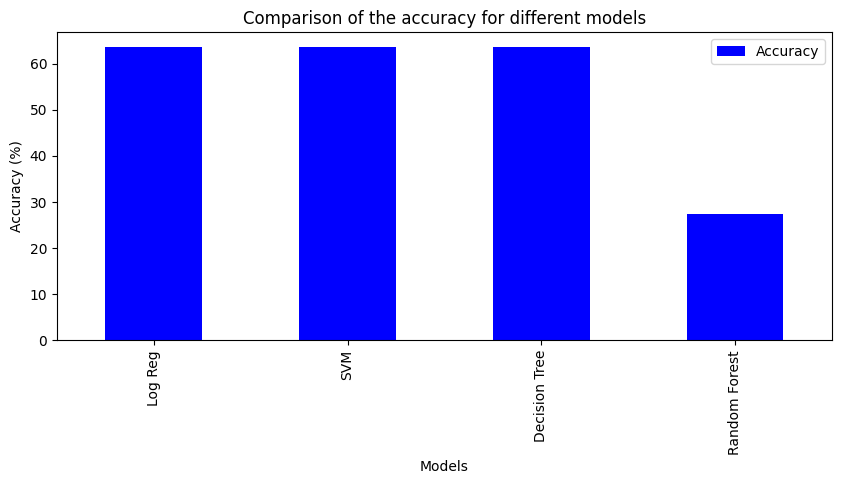

In [109]:
# Create a DataFrame to store the accuracies
plotdata = pd.DataFrame({
    "Accuracy": [logr_accuracy * 100, svm_accuracy * 100, dt_accuracy * 100, rf_accuracy * 100],
}, index=["Log Reg", "SVM", "Decision Tree", "Random Forest"])

# Define different colors for each bar
colors = ["blue", "green", "red", "orange"]

# Plot the accuracies using a bar chart with different colors
plotdata.plot(kind="bar", figsize=(10, 4), color=colors)
plt.title("Comparison of the accuracy for different models")
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.show()


### Link predictions using the best model

In [73]:
machine_state_ids = [16, 17,18, 19, 20, 21, 22]
component_ids = [13, 14, 15]

candidate_links = [[i, j] for i in component_ids for j in machine_state_ids]

In [80]:
# Use the trained Random Forest model to predict link existence for candidate links
predicted_probs = rf_model.predict_proba(candidate_links)[:, 1]  # Predict probabilities for class 1 (link exists)

threshold = 0.5  # You can choose a threshold value based on your preference or requirements
predicted_labels = (predicted_probs >= threshold).astype(int)

# The 'predicted_labels' now contains the link predictions (1 for link exists, 0 for no link) for each candidate link.
print("Link Predictions:")
for link, label in zip(candidate_links, predicted_labels):
    print(f"Candidate Link: {link}, Predicted Label: {label}")

Link Predictions:
Candidate Link: [13, 16], Predicted Label: 1
Candidate Link: [13, 17], Predicted Label: 1
Candidate Link: [13, 18], Predicted Label: 1
Candidate Link: [13, 19], Predicted Label: 1
Candidate Link: [13, 20], Predicted Label: 1
Candidate Link: [13, 21], Predicted Label: 1
Candidate Link: [13, 22], Predicted Label: 1
Candidate Link: [14, 16], Predicted Label: 1
Candidate Link: [14, 17], Predicted Label: 1
Candidate Link: [14, 18], Predicted Label: 1
Candidate Link: [14, 19], Predicted Label: 1
Candidate Link: [14, 20], Predicted Label: 1
Candidate Link: [14, 21], Predicted Label: 1
Candidate Link: [14, 22], Predicted Label: 1
Candidate Link: [15, 16], Predicted Label: 1
Candidate Link: [15, 17], Predicted Label: 1
Candidate Link: [15, 18], Predicted Label: 1
Candidate Link: [15, 19], Predicted Label: 1
Candidate Link: [15, 20], Predicted Label: 1
Candidate Link: [15, 21], Predicted Label: 1
Candidate Link: [15, 22], Predicted Label: 1


In [75]:
# Use the trained Random Forest model to predict link existence for candidate links
predicted_probs = rf_model.predict_proba(candidate_links)[:, 1]  # Predict probabilities for class 1 (link exists)

threshold = 0.5  # You can choose a threshold value based on your preference or requirements
predicted_labels = (predicted_probs >= threshold).astype(int)

# Combine candidate links and predicted labels
links_and_labels = list(zip(candidate_links, predicted_labels))

# Sort the candidate links based on predicted labels (1 before 0)
sorted_links_and_labels = sorted(links_and_labels, key=lambda x: x[1], reverse=True)

# Print the candidate links with link prediction of 1 first, then those with link prediction of 0
print("Link Predictions:")
for link, label in sorted_links_and_labels:
    print(f"Candidate Link: {link}, Predicted Label: {label}")

Link Predictions:
Candidate Link: [13, 16], Predicted Label: 1
Candidate Link: [13, 17], Predicted Label: 1
Candidate Link: [13, 18], Predicted Label: 1
Candidate Link: [13, 19], Predicted Label: 1
Candidate Link: [13, 20], Predicted Label: 1
Candidate Link: [13, 21], Predicted Label: 1
Candidate Link: [13, 22], Predicted Label: 1
Candidate Link: [14, 16], Predicted Label: 1
Candidate Link: [14, 17], Predicted Label: 1
Candidate Link: [14, 18], Predicted Label: 1
Candidate Link: [14, 19], Predicted Label: 1
Candidate Link: [14, 20], Predicted Label: 1
Candidate Link: [14, 21], Predicted Label: 1
Candidate Link: [14, 22], Predicted Label: 1
Candidate Link: [15, 16], Predicted Label: 1
Candidate Link: [15, 17], Predicted Label: 1
Candidate Link: [15, 18], Predicted Label: 1
Candidate Link: [15, 19], Predicted Label: 1
Candidate Link: [15, 20], Predicted Label: 1
Candidate Link: [15, 21], Predicted Label: 1
Candidate Link: [15, 22], Predicted Label: 1


In [40]:
# Close session and driver at the end
session.close()
driver.close()